In [1]:
import numpy as np
import scipy
import scipy.signal as signal
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import pywt
import wfdb
import math
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import svm
from skimage.restoration import denoise_wavelet
from random import shuffle

In [2]:
tags_ecg_feas1 = pd.read_csv(r"Data\\feas1\\rec_data_anon.csv")
tags_pt_feas1 = pd.read_csv(r"Data\\feas1\\pt_data_anon.csv")
key_1 = {'AF':2, 'maybeAF':3, 'noAF':4, 'other':1, 'undecided':6}
tags_ecg_feas2 = pd.read_csv(r"Data\\feas2\\rec_data_anon.csv")
tags_pt_feas2 = pd.read_csv(r"Data\\feas2\\pt_data_anon.csv")
key_2 = {'AF':1, 'maybeAF':2, 'noAF':3, 'noisy':4, 'undecided':6}
tags_ecg_trial = pd.read_csv(r"Data\\trial\\rec_data_anon_20240118.csv")
tags_pt_trial = pd.read_csv(r"Data\\trial\\pt_data_anon.csv")
key_t = {'AF':1, 'maybeAF':2, 'noAF':3, 'other':4, 'noisy':5, 'undecided':6}

C:\Users\docto\AppData\Local\Temp\ipykernel_8168\3583887908.py:7: DtypeWarning: Columns (35,37) have mixed types. Specify dtype option on import or set low_memory=False.
  tags_ecg_trial = pd.read_csv(r"Data\\trial\\rec_data_anon_20240118.csv")


In [3]:
def generate_filter(fs=500, low_cut=0.6, high_cut=40, N=1):
    return signal.butter(N=N, Wn=[low_cut, high_cut], btype='bandpass', analog=False, output='sos', fs=fs)

def apply_filters(ecg_signal, sos):
    return signal.sosfilt(sos, ecg_signal)

def filter_signal(ecg_signal, sos, N=1):
    # n = 0
    # if len(ecg_signal) != 15200: n = 15200 - len(ecg_signal)
    # ecg_signal = np.concatenate((ecg_signal, np.zeros(n)))
    DWTcoeffs = pywt.wavedec(ecg_signal, 'sym3')
    for i in range(1,8):
        DWTcoeffs[-i] = np.zeros_like(DWTcoeffs[-i])
    ecg_filtered = np.array(ecg_signal) - pywt.waverec(DWTcoeffs,'sym3',mode='symmetric',axis=-1)
    if N == 1:
        for _ in range(5):
            ecg_filtered = apply_filters(ecg_filtered, sos)
    else:
        ecg_filtered = apply_filters(ecg_filtered, sos)
    return ecg_filtered

def normalise_signals(ecg_signals):
    norm_ecg_signals = []
    for i in ecg_signals:
        norm_ecg_signals.append((np.array(i)-np.mean(i))/np.std(i))
    return norm_ecg_signals

def remove_jumps(ecg_signal_orig):
    ecg_signal = np.copy(ecg_signal_orig)
    diff = np.diff(ecg_signal)
    avg_diff = np.average(np.abs(diff))
    for j, i in enumerate(diff):
        if j < 50: 
            if i > 3*avg_diff:
                if -np.min(diff[j:j+50]) < 0.5*i or i > 6*avg_diff:
                    ecg_signal[j+1:] -= i
            elif i < -3*avg_diff:
                if j == 0:
                    ecg_signal[j+1:] -= i
                elif np.max(diff[:j]) < -0.5*i or i < -6*avg_diff:
                    ecg_signal[j+1:] -= i
        elif i > 3*avg_diff:
            if -np.min(diff[j:j+50]) < 0.5*i or i > 6*avg_diff:
                ecg_signal[j+1:] -= i
        elif i < -3*avg_diff:
            if np.max(diff[j-50:j]) < -0.5*i or i < -6*avg_diff:
                ecg_signal[j+1:] -= i
    return ecg_signal

def filter_signals(ecg_signals, low_cut=0.6, high_cut=40, N=1):
    sos = generate_filter(low_cut=low_cut, high_cut=high_cut, N=N)
    for j in range(len(ecg_signals)):
        ecg_signals[j] = filter_signal(remove_jumps(ecg_signals[j]), sos)
    return normalise_signals(ecg_signals)
    
def performance(y_true, y_pred):
    TP = sum([1 for i, j in zip(y_true, y_pred) if i == 1 and j == 1])
    FP = sum([1 for i, j in zip(y_true, y_pred) if i == 0 and j == 1])
    FN = sum([1 for i, j in zip(y_true, y_pred) if i == 1 and j == 0])
    TN = sum([1 for i, j in zip(y_true, y_pred) if i == 0 and j == 0])
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1_score = 2*(precision*recall)/(precision + recall)

    return [f1_score, precision, recall, [[TP, FP], [FN, TN]]]

In [4]:
class ecg:

    def __init__(self, tags_ecg_feas1 = tags_ecg_feas1, tags_pt_feas1 = tags_pt_feas1, 
                 tags_ecg_feas2 = tags_ecg_feas2, tags_pt_feas2 = tags_pt_feas2, 
                 key_1 = key_1, key_2 = key_2):
        self.tags_ecg_1 = np.array(pd.DataFrame(tags_ecg_feas1))
        self.tags_pt_1 = np.array(pd.DataFrame(tags_pt_feas1))
        self.tags_ecg_2 = np.array(pd.DataFrame(tags_ecg_feas2))
        self.tags_pt_2 = np.array(pd.DataFrame(tags_pt_feas2))
        self.tags_ecg_t = np.array(pd.DataFrame(tags_ecg_trial))
        self.tags_pt_t = np.array(pd.DataFrame(tags_pt_trial))

        self.tags_pt_ecg_1 = np.array(pd.DataFrame(tags_ecg_feas1, columns=['ptID', 'measNo', 'measID']))
        self.tags_pt_ecg_2 = np.array(pd.DataFrame(tags_ecg_feas2, columns=['ptID', 'measNo', 'measID']))
        self.tags_pt_ecg_t = np.array(pd.DataFrame(tags_ecg_trial, columns=['ptID', 'measNo', 'measID']))
        self.tags_pt_info_1 = np.array(pd.DataFrame(tags_pt_feas1, columns=['ptID', 'ptDiag']))
        self.tags_pt_info_2 = np.array(pd.DataFrame(tags_pt_feas2, columns=['ptID', 'ptDiag']))
        self.tags_pt_info_t = np.array(pd.DataFrame(tags_pt_trial, columns=['ptID', 'ptDiag']))
        self.tags_ecg_info_1 = np.array(pd.DataFrame(tags_ecg_feas1, columns=['measID', 'measDiag', 'ptDiag', 'measDiagAgree']))
        self.tags_ecg_info_2 = np.array(pd.DataFrame(tags_ecg_feas2, columns=['measID', 'measDiag', 'ptDiag']))
        self.tags_ecg_info_t = np.array(pd.DataFrame(tags_ecg_trial, columns=['measID', 'measDiag', 'ptDiag', 'measDiagAgree']))

        self.key_1 = key_1
        self.key_2 = key_2
        self.key_t = key_t
        self.ecg_num_1 = 162515
        self.ecg_num_2 = 23253
        self.ecg_num_t = 1104005
        self.pt_num_1 = 2141
        self.pt_num_2 = 288
        self.pt_num_t = 13453

    def extract_signal(self, measID, study = 'feas1'):
        if study == 'feas1':
            ecg_IDs, num_ecgs, file_head = self.tags_pt_ecg_1, self.ecg_num_1, 'saferF1_pt'
        elif study == 'feas2':
            ecg_IDs, num_ecgs, file_head = self.tags_pt_ecg_2, self.ecg_num_2, 'saferF2_pt'
        elif study == 'trial':
            ecg_IDs, num_ecgs, file_head = self.tags_pt_ecg_t, self.ecg_num_t, 'saferT_pt'

        assert measID < num_ecgs and measID == ecg_IDs[measID-1,-1]
        ptID, measNo = ecg_IDs[measID-1,0], ecg_IDs[measID-1,1]
        ptID_vis, folder_vis = self.file_strs(ptID)

        try:
            ecg_signal = wfdb.rdrecord('Data\\ECGs\\'+study+'\\'+folder_vis+'\\'+file_head+ptID_vis)
        except FileNotFoundError:
            print('Incorrect .dat file assigned to patient '+str(ptID)+' for study '+study)
            return
        except TypeError:
            print('Weird error for measID '+str(measID)+' for study '+study)
            return
        
        if len(ecg_signal.p_signal[0]) < measNo:
            print('Expected measurement '+str(measNo)+' for patient '+str(ptID)+' for study '+study+' not in file')
        else:
            return np.array(ecg_signal.p_signal[:,measNo-1])
    
    def file_strs(self, ptID):
        ptID_vis = '0'*(6-len(str(ptID)))+str(ptID)
        folder_vis = '0'*(4-len(str(ptID//100)))+str(ptID//100)+'0'*2
        return ptID_vis, folder_vis
        
    def extract_tags(self, measID_num, study = 'feas2'):
        if study == 'feas2':
            if measID_num > self.ecg_num_2: raise Exception('Not a valid measID')
            tags = self.tags_ecg_2[measID_num-1]
        elif study == 'feas1':
            if measID_num > self.ecg_num_1: raise Exception('Not a valid measID')
            tags = self.tags_ecg_1[measID_num-1]
        elif study == 'trial':
            if measID_num > self.ecg_num_t: raise Exception('Not a valid measID')
            tags = self.tags_ecg_t[measID_num-1]
        assert tags['measID'] == measID_num                   
        return tags
    
    def extract_label(self, tags):
        return tags['measDiag']
    
    def extract_cardiolund_tags(self, tags, study = 'feas2'):
        if study == 'feas2':
            cld_tags = list(tags.iloc[22:37]) 
        elif study == 'feas1':
            cld_tags =  list(tags.iloc[25:40])
        elif study == 'trial':
            cld_tags =  list(tags.iloc[25:40])
        # if 1 in [1 for i in cld_tags if math.isnan(i)]:
        if any(math.isnan(cld_tags)):
            return None
        else:
            return cld_tags
        
    def test_clean(self, measID, study = 'feas2'):
        if study == 'feas2':
            cld_tags = self.tags_ecg_2[measID-1][23:35]
        elif study == 'feas1':
            cld_tags =  self.tags_ecg_1[measID-1][26:46]
        elif study == 'trial':
            cld_tags =  self.tags_ecg_t[measID-1][23:35]
            
        if all(cld_tags == 0):
            return True
        else:
            return False
    
    def extract_pt_measIDs(self, ptID_num, study = 'feas2'):
        if study == 'feas2':
            tags_ecg = self.tags_pt_ecg_2
            ecg_num = self.ecg_num_2
        elif study == 'feas1':
            tags_ecg = self.tags_pt_ecg_1
            ecg_num = self.ecg_num_1
        ptID_measIDs = []
        i = [j[0] for j in tags_ecg].index(ptID_num)
        while i < ecg_num and tags_ecg[i][0] == ptID_num:
            ptID_measIDs.append(tags_ecg[i][-1])
            i += 1
        return ptID_measIDs
    
    def extract_measID_pt(self, measID_num, study = 'feas2'):
        if study == 'feas2':
            tags_ecg = self.tags_pt_ecg_2
        elif study == 'feas1':
            tags_ecg = self.tags_pt_ecg_1
        return [j[0] for j in tags_ecg if j[2] == measID_num][0]
    
    def extract_measIDs(self, tag = 'AF', study = 'feas2', clean = True):
        if study == 'feas1':
            tags_ecg, key = self.tags_ecg_info_1, self.key_1
        elif study == 'feas2':
            tags_ecg, key = self.tags_ecg_info_2, self.key_2
        elif study == 'trial':
            tags_ecg, key = self.tags_ecg_info_t, self.key_t

        diag = key[tag]
        if tag == 'noAF':
            diag_undec = key['undecided']
            # if study == 'feas1':
            #     diag_noAF = [diag]
            # elif study == 'feas2':
            #     diag_noAF = [diag, key['other']]
            # elif study == 'trial':
            #     diag_noAF = [diag, key['other']]
            measIDs = [i[0] for i in tags_ecg if i[1] == diag] #  or (i[1] == diag_undec and i[2] == diag)
            if clean:
                return [i for i in measIDs if self.test_clean(i, study=study)]
            else:
                return measIDs
        else:
            return [i[0] for i in tags_ecg if i[1] == diag]
    
    def extract_ptIDs(self, tag = 'AF', study = 'feas2'):
        if study == 'feas2':
            tags_ecg = self.tags_pt_info_2
            key = self.key_2
        elif study == 'feas1':
            tags_ecg = self.tags_pt_info_1
            key = self.key_1
        elif study == 'trial':
            tags_ecg = self.tags_pt_info_t
            key = self.key_t
        
        diag = key[tag]
        return [i[0] for i in tags_ecg if i[1] == diag]
    
    def store_ecg_tags(self, tag = 'AF', study = 'feas2', measIDs = None):
        if measIDs is None: 
            measIDs = self.extract_measIDs(tag=tag, study=study)
        data = []
        for i in measIDs:
            tags = self.extract_tags(i, study = study)
            cdl_tags = self.extract_cardiolund_tags(tags, study = study)
            if cdl_tags is not None:
                data.append(cdl_tags)
        return data
    
    def store_ecg_data(self, tag = 'AF', study = 'feas2', measIDs = None, length = None, clean = True):
        if not measIDs:
            measIDs = self.extract_measIDs(tag=tag, study=study, clean=clean)
        if length and length < len(measIDs):
            measIDs = np.random.permutation(measIDs)[:length]
        else:
            measIDs = np.random.permutation(measIDs)
        data = []
        for i in measIDs:
            extracted_signal = self.extract_signal(i, study=study)
            if type(extracted_signal) == np.ndarray:
                data.append(extracted_signal)
        return data, measIDs


In [5]:
ecg = ecg()

In [6]:
print(ecg.tags_ecg_1[4600][26:46])
print(ecg.tags_ecg_2[4600][23:35])
print(ecg.tags_ecg_t[4600][23:35])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 1 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0]


In [7]:
raw = ecg.extract_signal(798843, 'trial')
test_filter = filter_signals([raw], low_cut=0.6, high_cut=40)[0]
# test = remove_jumps(test)

low_pass = signal.butter(N=1, Wn=40, btype='lowpass', analog=False, output='sos', fs=500)
high_pass = signal.butter(N=1, Wn=0.6, btype='highpass', analog=False, output='sos', fs=500)
sos = generate_filter(low_cut=0.6, high_cut=40, N=1)

test = raw.copy()
for _ in range(5):
    test = apply_filters(test, low_pass)

test = remove_jumps(test)

# DWTcoeffs = pywt.wavedec(ecg_signal, 'sym3')
# for i in range(1,8):
#     DWTcoeffs[-i] = np.zeros_like(DWTcoeffs[-i])
# ecg_filtered = np.array(ecg_signal) - pywt.waverec(DWTcoeffs,'sym3',mode='symmetric',axis=-1)


DWTcoeffs = pywt.wavedec(test, 'sym3')
for i in list(range(len(DWTcoeffs)-8)):
    DWTcoeffs[i] = np.zeros_like(DWTcoeffs[i])


# DWTcoeffs = pywt.wavedec(test, 'sym3', level=7)
# DWTcoeffs[0] = np.zeros_like(DWTcoeffs[0])
# DWTcoeffs[1] = np.zeros_like(DWTcoeffs[1])
# DWTcoeffs[2] = np.zeros_like(DWTcoeffs[2])
# DWTcoeffs[3] = np.zeros_like(DWTcoeffs[3])
# DWTcoeffs[4] = np.zeros_like(DWTcoeffs[4])
# DWTcoeffs[5] = np.zeros_like(DWTcoeffs[5])
# DWTcoeffs[6] = np.zeros_like(DWTcoeffs[6])
# DWTcoeffs[7] = np.zeros_like(DWTcoeffs[7])

test_wavelet = pywt.waverec(DWTcoeffs,'sym3',mode='symmetric',axis=-1)

for _ in range(5):
    test_wavelet = apply_filters(test_wavelet, high_pass)

In [8]:
print(list(range(1,5)) + list(range(9,17)))

[1, 2, 3, 4, 9, 10, 11, 12, 13, 14, 15, 16]


19.969720593201274
[ 0.         21.72869697  0.         ...  0.          0.
  0.        ]


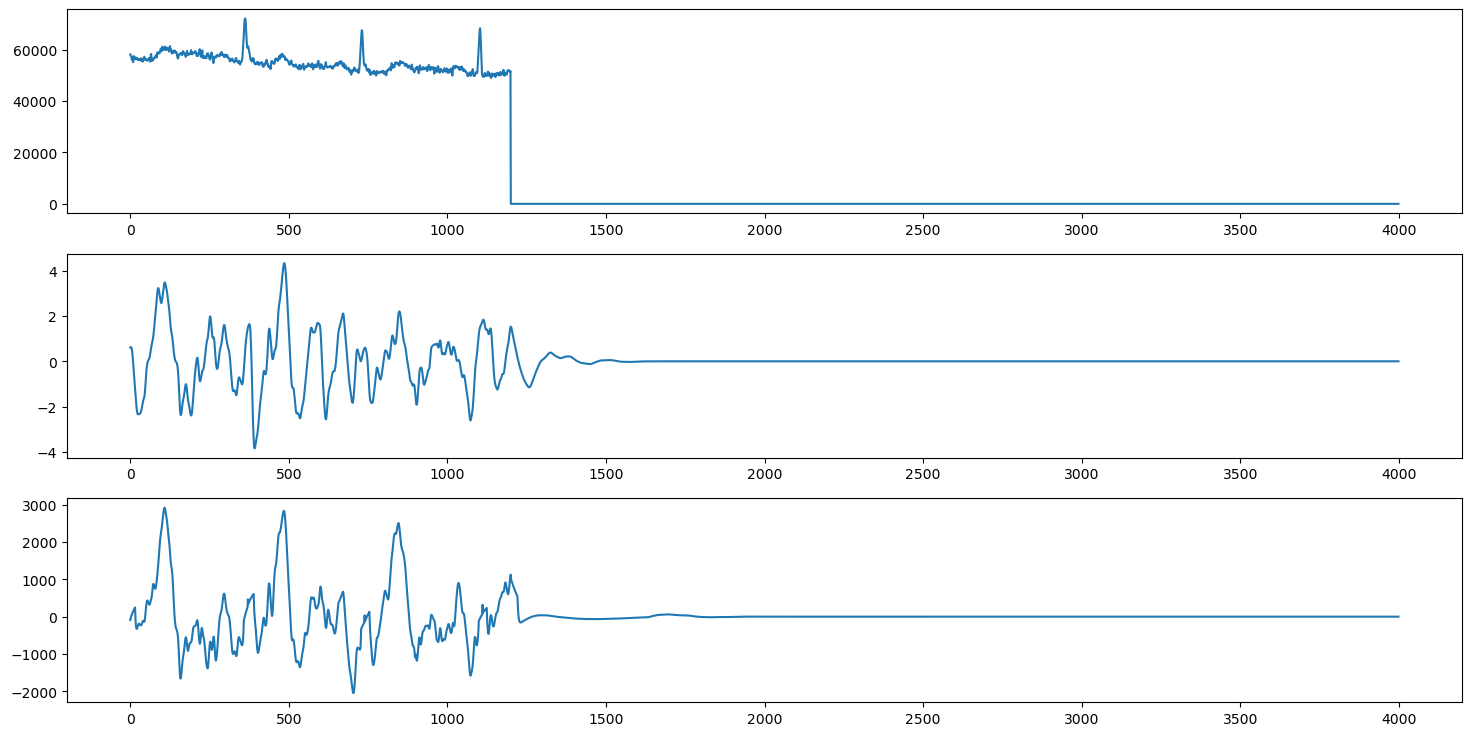

In [9]:
start, end = 4000, 8000
print(np.average(np.abs(np.diff(test))))
print(np.diff(test)[start:end])
fig, ax = plt.subplots(3,1)
fig.set_figwidth(18)
fig.set_figheight(9)
plt.subplot(3,1,1)
plt.plot(raw[start:end])
plt.subplot(3,1,2)
plt.plot(test_filter[start:end])
plt.subplot(3,1,3)
plt.plot(test_wavelet[start:end])

In [10]:
data_AF_feas1, measIDs_AF_feas1 = ecg.store_ecg_data(tag='AF', study='feas1')
data_noAF_feas1, measIDs_noAF_feas1 = ecg.store_ecg_data(tag='noAF', study='feas1', clean=False)
print(len(measIDs_AF_feas1), len(measIDs_noAF_feas1))

data_AF_trial, measIDs_AF_trial = ecg.store_ecg_data(tag='AF', study='trial')
data_noAF_trial, measIDs_noAF_trial = ecg.store_ecg_data(tag='noAF', study='trial', length=5000, clean=False)
print(len(measIDs_AF_trial), len(measIDs_noAF_trial))

Incorrect .dat file assigned to patient 1891 for study feas1
Incorrect .dat file assigned to patient 1891 for study feas1
Incorrect .dat file assigned to patient 1891 for study feas1
Incorrect .dat file assigned to patient 1891 for study feas1
Incorrect .dat file assigned to patient 1891 for study feas1
Incorrect .dat file assigned to patient 1891 for study feas1
Incorrect .dat file assigned to patient 1891 for study feas1
Incorrect .dat file assigned to patient 1891 for study feas1
Incorrect .dat file assigned to patient 1891 for study feas1
Incorrect .dat file assigned to patient 1891 for study feas1
Incorrect .dat file assigned to patient 1891 for study feas1
Incorrect .dat file assigned to patient 800 for study feas1
Incorrect .dat file assigned to patient 800 for study feas1
Incorrect .dat file assigned to patient 1891 for study feas1
822 3127
2387 5000


In [11]:
ntrain = 3200
nval = 1600
ntest = 1600

ptrainAF = 0.5
pvalAF = 0.5
ptestAF = 0.5

ntrainAF = round(ntrain*ptrainAF)
nvalAF = round(nval*pvalAF)
ntestAF = round(ntest*ptestAF)

trial_cut = ntrainAF + nvalAF - ntestAF

data_AF, measIDs_AF = list(data_AF_feas1) + list(data_AF_trial[:trial_cut]), list(measIDs_AF_feas1) + list(measIDs_AF_trial[:trial_cut])
studies_AF = np.array(['feas1']*len(data_AF_feas1) + ['trial']*trial_cut)
permutation = np.random.permutation(np.array(data_AF).shape[0])
data_AF, measIDs_AF, studies_AF = np.array(data_AF)[permutation,:], np.array(measIDs_AF)[permutation], np.array(studies_AF)[permutation]

data_train_AF, measIDs_train_AF, studies_train_AF = data_AF[:ntrainAF], measIDs_AF[:ntrainAF], studies_AF[:ntrainAF]
data_val_AF, measIDs_val_AF, studies_val_AF = data_AF[ntrainAF:], measIDs_AF[ntrainAF:], studies_AF[ntrainAF:]
data_test_AF, measIDs_test_AF, studies_test_AF = data_AF_trial[trial_cut:trial_cut+ntestAF], measIDs_AF_trial[trial_cut:trial_cut+ntestAF], np.array(['trial']*ntestAF)

data_train_noAF, measIDs_train_noAF, studies_train_noAF = data_noAF_trial[:ntrain-ntrainAF], measIDs_noAF_trial[:ntrain-ntrainAF], np.array(['trial']*(ntrain-ntrainAF))
data_val_noAF, measIDs_val_noAF, studies_val_noAF = data_noAF_trial[ntrain-ntrainAF:ntrain+nval-ntrainAF-nvalAF], measIDs_noAF_trial[ntrain-ntrainAF:ntrain+nval-ntrainAF-nvalAF], np.array(['trial']*(nval-nvalAF))
data_test_noAF, measIDs_test_noAF, studies_test_noAF = data_noAF_trial[ntrain+nval-ntrainAF-nvalAF:ntrain+nval+ntest-ntrainAF-nvalAF-ntestAF], measIDs_noAF_trial[ntrain+nval-ntrainAF-nvalAF:ntrain+nval+ntest-ntrainAF-nvalAF-ntestAF], np.array(['trial']*(ntest-ntestAF))

In [12]:
data_train, measIDs_train, studies_train = np.concatenate((data_train_AF, data_train_noAF)), np.concatenate((measIDs_train_AF, measIDs_train_noAF)), np.concatenate((studies_train_AF, studies_train_noAF))
ytrain = np.array([1]*len(data_train_AF) + [0]*len(data_train_noAF))
data_val, measIDs_val, studies_val = np.concatenate((data_val_AF, data_val_noAF)), np.concatenate((measIDs_val_AF, measIDs_val_noAF)), np.concatenate((studies_val_AF, studies_val_noAF))
yval = np.array([1]*len(data_val_AF) + [0]*len(data_val_noAF))
data_test, measIDs_test, studies_test = np.concatenate((data_test_AF, data_test_noAF)), np.concatenate((measIDs_test_AF, measIDs_test_noAF)), np.concatenate((studies_test_AF, studies_test_noAF))
ytest = np.array([1]*len(data_test_AF) + [0]*len(data_test_noAF))

print(len(ytrain), np.sum(ytrain))
print(len(yval), np.sum(yval))
print(len(ytest), np.sum(ytest))

3200 1600
1617 817
1587 787


In [14]:
xtrain = np.array(filter_signals(data_train))
xval = np.array(filter_signals(data_val))
xtest = np.array(filter_signals(data_test))

0 360867


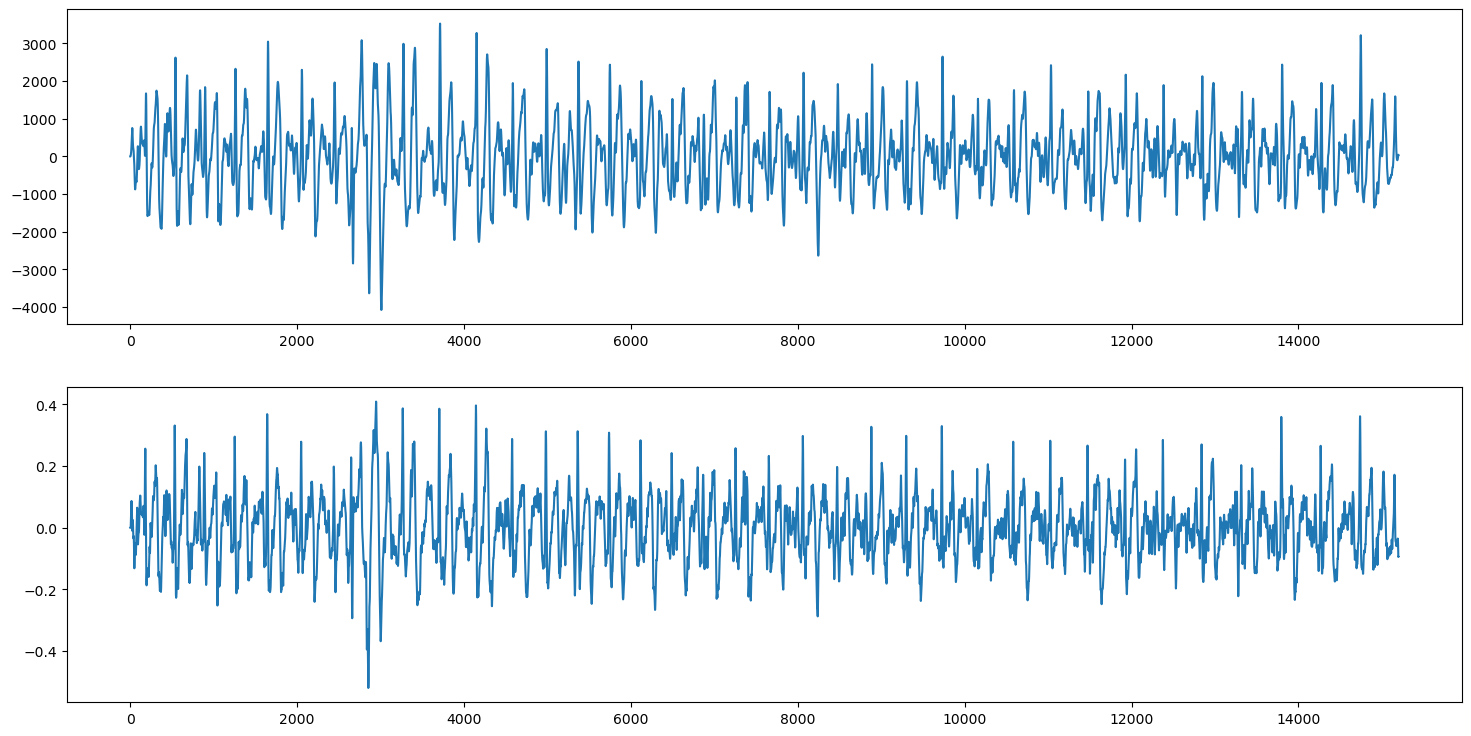

In [17]:
n = 1928

filter_test = np.copy(data_train[n])
sauce = signal.butter(N=1, Wn=40, btype='lowpass', analog=False, output='sos', fs=500)
filter_test = filter_signal(filter_test, sauce)

start, end = 0, -1
fig, ax = plt.subplots(2,1)
fig.set_figwidth(18)
fig.set_figheight(9)
plt.subplot(2,1,1)
plt.plot(filter_test[start:end])
plt.subplot(2,1,2)
plt.plot(data_train[n][start:end]/10000)
print(ytrain[n], measIDs_train[n])

In [18]:
ks = 20

cnn = tf.keras.models.Sequential()
cnn.add(tf.keras.layers.Conv1D(filters=16, kernel_size=ks, activation='relu', input_shape=[15200,1]))
cnn.add(tf.keras.layers.MaxPool1D(pool_size=10, strides=2))
cnn.add(tf.keras.layers.Conv1D(filters=16, kernel_size=ks, activation='relu'))
cnn.add(tf.keras.layers.MaxPool1D(pool_size=10, strides=2))
cnn.add(tf.keras.layers.Conv1D(filters=16, kernel_size=ks, activation='relu'))
cnn.add(tf.keras.layers.MaxPool1D(pool_size=10, strides=2))
cnn.add(tf.keras.layers.Conv1D(filters=16, kernel_size=ks, activation='relu'))
cnn.add(tf.keras.layers.MaxPool1D(pool_size=10, strides=2))
cnn.add(tf.keras.layers.Conv1D(filters=16, kernel_size=ks, activation='relu'))
cnn.add(tf.keras.layers.MaxPool1D(pool_size=10, strides=2))
cnn.add(tf.keras.layers.Conv1D(filters=16, kernel_size=ks, activation='relu'))
cnn.add(tf.keras.layers.MaxPool1D(pool_size=10, strides=2))
cnn.add(tf.keras.layers.Conv1D(filters=16, kernel_size=ks, activation='relu'))
cnn.add(tf.keras.layers.MaxPool1D(pool_size=10, strides=2))
cnn.add(tf.keras.layers.Conv1D(filters=16, kernel_size=ks, activation='relu'))
cnn.add(tf.keras.layers.MaxPool1D(pool_size=10, strides=2))
cnn.add(tf.keras.layers.Conv1D(filters=16, kernel_size=ks, activation='relu'))
cnn.add(tf.keras.layers.MaxPool1D(pool_size=10, strides=2))
cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dense(units=128, activation='sigmoid'))
cnn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [19]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 15181, 16)         336       
                                                                 
 max_pooling1d (MaxPooling1  (None, 7586, 16)          0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 7567, 16)          5136      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 3779, 16)          0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 3760, 16)          5136      
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 1876, 16)          0

In [20]:
history = cnn.fit(xtrain, ytrain, epochs=24, validation_data=(xval, yval))

Epoch 1/24
100/100 [==============================] - 41s 393ms/step - loss: 0.6650 - accuracy: 0.5788 - val_loss: 0.5632 - val_accuracy: 0.7539
Epoch 2/24
100/100 [==============================] - 43s 430ms/step - loss: 0.5271 - accuracy: 0.7509 - val_loss: 0.4351 - val_accuracy: 0.8058
Epoch 3/24
100/100 [==============================] - 43s 431ms/step - loss: 0.4205 - accuracy: 0.8050 - val_loss: 0.3660 - val_accuracy: 0.8528
Epoch 4/24
100/100 [==============================] - 40s 404ms/step - loss: 0.3904 - accuracy: 0.8316 - val_loss: 0.3457 - val_accuracy: 0.8621
Epoch 5/24
100/100 [==============================] - 41s 408ms/step - loss: 0.3580 - accuracy: 0.8441 - val_loss: 0.3476 - val_accuracy: 0.8528
Epoch 6/24
100/100 [==============================] - 43s 433ms/step - loss: 0.3312 - accuracy: 0.8609 - val_loss: 0.3621 - val_accuracy: 0.8386
Epoch 7/24
100/100 [==============================] - 45s 454ms/step - loss: 0.3235 - accuracy: 0.8619 - val_loss: 0.3073 - val_ac

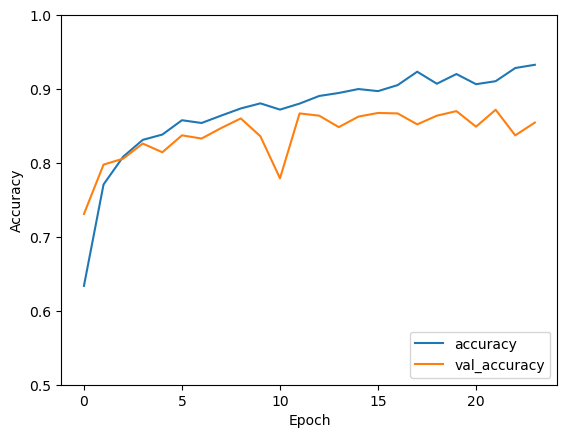

50/50 [==============================] - 3s 60ms/step
[0.8607594936708861, 0.8188073394495413, 0.9072426937738246, [[714, 158], [73, 642]]]
[858600, 43777, 41850, 790352, 94985, 111342, 519719, 519715, 798048, 424714, 375017, 30184, 964470, 1048718, 295372, 605837, 68942, 111338, 286057, 1086283, 974257, 792023, 434145, 623142, 678909, 111362, 1062387, 111355, 798086, 801214, 111372, 891558, 430444, 920408, 569789, 327319, 872107, 41870, 30189, 496976, 959186, 1007193, 340787, 1022301, 845606, 233538, 890976, 114589, 1081945, 39291, 845591, 233594, 974192, 1091762, 111352, 523528, 327331, 161231, 974214, 140153, 1076246, 114388, 193464, 916348, 187450, 135380, 255628, 460022, 1025583, 1086282, 253005, 28725, 111348]
[719373, 325443, 230630, 119490, 638818, 559353, 3149, 698536, 82083, 971044, 633501, 254950, 635877, 754761, 464869, 193955, 219300, 273478, 250276, 122947, 40673, 1013971, 961989, 199877, 355621, 926827, 758348, 764933, 885667, 347396, 626557, 826523, 459856, 346161, 6963

Text(0, 0.5, 'Actual class')

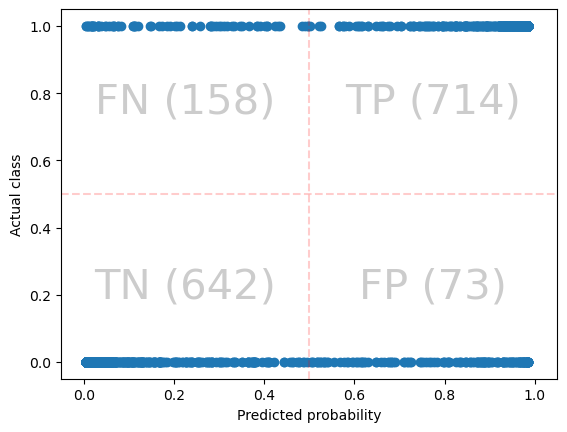

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

pred_prob = cnn.predict(xtest)
ypred = np.round(pred_prob)

p = performance(ytest, ypred)
print(p)
measIDs_FN = [measIDs_test[i] for i in range(len(ytest)) if ytest[i] == 1 and ypred[i] == 0]
measIDs_FP = [measIDs_test[i] for i in range(len(ytest)) if ytest[i] == 0 and ypred[i] == 1]
probs_wrong = [pred_prob[i][0] for i in range(len(ytest)) if ytest[i] != ypred[i]]
print(measIDs_FN)
print(measIDs_FP)
print(probs_wrong)

plt.scatter(pred_prob, ytest)
plt.hlines(0.5, -0.05, 1.05,'r','dashed', alpha=0.2)
plt.vlines(0.5, -0.05, 1.05,'r','dashed', alpha=0.2)
plt.text(0.775, 0.775, 'TP ('+str(p[3][0][0])+')', size=30, ha="center", va="center", alpha=0.2)
plt.text(0.775, 0.225, 'FP ('+str(p[3][1][0])+')', size=30, ha="center", va="center", alpha=0.2)
plt.text(0.225, 0.775, 'FN ('+str(p[3][0][1])+')', size=30, ha="center", va="center", alpha=0.2)
plt.text(0.225, 0.225, 'TN ('+str(p[3][1][1])+')', size=30, ha="center", va="center", alpha=0.2)
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
plt.xlabel('Predicted probability')
plt.ylabel('Actual class')

In [ ]:
x = np.array(filter_signals(data, high_cut=40))
xtest = np.array(filter_signals(datatest, high_cut=40))

n = 800

x = np.concatenate((x, xtest[:n]))
xtest = xtest[n:]

print(len(x), sum(y))
print(len(xtest), sum(ytest))

n = len(x)
ntest = len(xtest)
ntrain = round(n*2/3)
nval = n - ntrain
print(ntrain, nval, ntest)

xtrain = x[:ntrain]
ytrain = y[:ntrain]
measIDtrain = measIDs[:ntrain]

xval = x[ntrain:]
yval = y[ntrain:]
measIDval = measIDs[ntrain:]

# xtest = x[ntrain+nval:]
# ytest = y[ntrain+nval:]
# measIDtest = measIDs[ntrain+nval:]

print(sum(ytrain), sum(yval), sum(ytest))

ks = 20

cnn = tf.keras.models.Sequential()
cnn.add(tf.keras.layers.Conv1D(filters=16, kernel_size=ks, activation='relu', input_shape=[15200,1]))
cnn.add(tf.keras.layers.MaxPool1D(pool_size=10, strides=2))
cnn.add(tf.keras.layers.Conv1D(filters=16, kernel_size=ks, activation='relu'))
cnn.add(tf.keras.layers.MaxPool1D(pool_size=10, strides=2))
cnn.add(tf.keras.layers.Conv1D(filters=16, kernel_size=ks, activation='relu'))
cnn.add(tf.keras.layers.MaxPool1D(pool_size=10, strides=2))
cnn.add(tf.keras.layers.Conv1D(filters=16, kernel_size=ks, activation='relu'))
cnn.add(tf.keras.layers.MaxPool1D(pool_size=10, strides=2))
cnn.add(tf.keras.layers.Conv1D(filters=16, kernel_size=ks, activation='relu'))
cnn.add(tf.keras.layers.MaxPool1D(pool_size=10, strides=2))
cnn.add(tf.keras.layers.Conv1D(filters=16, kernel_size=ks, activation='relu'))
cnn.add(tf.keras.layers.MaxPool1D(pool_size=10, strides=2))
cnn.add(tf.keras.layers.Conv1D(filters=16, kernel_size=ks, activation='relu'))
cnn.add(tf.keras.layers.MaxPool1D(pool_size=10, strides=2))
cnn.add(tf.keras.layers.Conv1D(filters=16, kernel_size=ks, activation='relu'))
cnn.add(tf.keras.layers.MaxPool1D(pool_size=10, strides=2))
cnn.add(tf.keras.layers.Conv1D(filters=16, kernel_size=ks, activation='relu'))
cnn.add(tf.keras.layers.MaxPool1D(pool_size=10, strides=2))
cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dense(units=128, activation='sigmoid'))
cnn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

history = cnn.fit(xtrain, ytrain, epochs=24, validation_data=(xval, yval))

pred_prob = cnn.predict(xtest)
ypred = np.round(pred_prob)

p = performance(ytest, ypred)
print(p)

5626 2424
786 780
3751 1875 786
1875 549 780
Epoch 1/24
118/118 [==============================] - ETA: 0s - loss: 0.6964 - accuracy: 0.4953

ValueError: Data cardinality is ambiguous:
  x sizes: 1875
  y sizes: 1075
Make sure all arrays contain the same number of samples.

In [ ]:
print(performance(ytest, ypred))
measIDs_FN = [measIDstest[i] for i in range(len(ytest)) if ytest[i] == 1 and ypred[i] == 0]
measIDs_FP = [measIDstest[i] for i in range(len(ytest)) if ytest[i] == 0 and ypred[i] == 1]
probs_wrong = [pred_prob[i][0] for i in range(len(ytest)) if ytest[i] != ypred[i]]
print(measIDs_FN)
print(measIDs_FP)
print(probs_wrong)

[0.842042042042042, 0.792090395480226, 0.8987179487179487, [[701, 184], [79, 622]]]
[496976, 327322, 91565, 1025577, 872325, 327304, 962189, 1006147, 233568, 964470, 623142, 226845, 430444, 934535, 300914, 845602, 801206, 1076246, 956717, 974257, 723479, 519785, 335117, 135380, 434145, 858600, 519063, 959186, 775797, 365475, 731566, 370823, 193490, 825244, 1043861, 53503, 340794, 351007, 327312, 872327, 41850, 1018344, 438286, 1025579, 929890, 340787, 1006211, 68942, 300940, 245444, 845589, 661364, 135333, 233594, 438119, 25786, 365061, 845611, 245445, 789429, 368871, 17576, 974196, 213000, 690141, 1048718, 370824, 798086, 845655, 704709, 217965, 469099, 845622, 351000, 1007193, 1043862, 523528, 974199, 327274]
[949799, 1072101, 399944, 559522, 63372, 1067092, 6728, 482446, 340118, 3148, 231908, 262785, 745957, 1020587, 1069609, 518739, 188170, 102105, 1064884, 845996, 309543, 381384, 45662, 447987, 567570, 432432, 713528, 918896, 1093946, 961656, 481084, 445417, 707950, 949851, 106709

In [ ]:
# start, end = 6000, 10000

# for i in measIDs_FN:
#     fig, ax = plt.subplots(2,1)
#     fig.set_figwidth(18)
#     fig.set_figheight(10)
#     ax[0].plot(filter_signals([ecg.extract_signal(i, study='trial')])[0][start:end])
#     ax[0].set_title('Filtered signal')
#     ax[1].plot(ecg.extract_signal(i, study='trial')[start:end]/1000)
#     ax[1].set_title('Raw signal')
#     fig.suptitle('False Negative for measID '+str(i)+' in trial', fontsize=18)
#     fig.savefig('E:\IIB Project\Experiments\Experiment 6\FN\FN'+str(i)+'.png', bbox_inches='tight')

# for i in measIDs_FP:
#     fig, ax = plt.subplots(2,1)
#     fig.set_figwidth(18)
#     fig.set_figheight(10)
#     ax[0].plot(filter_signals([ecg.extract_signal(i, study='trial')])[0][start:end])
#     ax[0].set_title('Filtered signal')
#     ax[1].plot(ecg.extract_signal(i, study='trial')[start:end]/1000)
#     ax[1].set_title('Raw signal')
#     fig.suptitle('False Positive for measID '+str(i)+' in trial', fontsize=18)
#     fig.savefig('E:\IIB Project\Experiments\Experiment 6\FP\FP'+str(i)+'.png', bbox_inches='tight')